#### [지도학습 - 회귀]
- 회귀(Regression) : 수치값을 예측하는 학습
    * 예: 거리, 시간, 무게, 집가격 등등 ...

- 주제 : 생선 길이에 따른 무게를 예측하는 모델
- 방법 : 최근접이웃 알고리즘

[1] 모듈 로딩 및 데이터 준비 <hr>

In [67]:
# ========================================================
# [1-1] 모듈 로딩
# ========================================================
# 기본 모듈
import pandas as pd
import numpy as np

# 시각화
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 머신러닝 데이터셋 및 학습관련 모듈
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# CoW 활성화 : 복사와 공유 자동 설정 기능
pd.options.mode.copy_on_write = True

# 판다스/넘파이에 지수표기법(과학적표기법) 정지 설정
pd.options.display.float_format = '{:.5f}'.format
np.set_printoptions(precision=6, suppress=True)

In [68]:
# ========================================================
# [1-2] 데이터 준비 및 확인
# ========================================================

# 데이터 준비
FILE_NAME = '../Data/fish_train_10500.csv'

# Bream, Smelt 생선 데이터만 추출
fishDF = pd.read_csv(FILE_NAME, usecols=[0, 1, 5])

(fishDF.Species == 'Bream') | (fishDF.Species == 'Smelt')

dataDF = fishDF[fishDF.Species.isin(['Bream', 'Smelt'])]

dataDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3000 entries, 0 to 10499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Weight   3000 non-null   float64
 1   Length   3000 non-null   float64
 2   Species  3000 non-null   object 
dtypes: float64(2), object(1)
memory usage: 93.8+ KB


        Weight  Length
Weight 1.00000 0.96938
Length 0.96938 1.00000


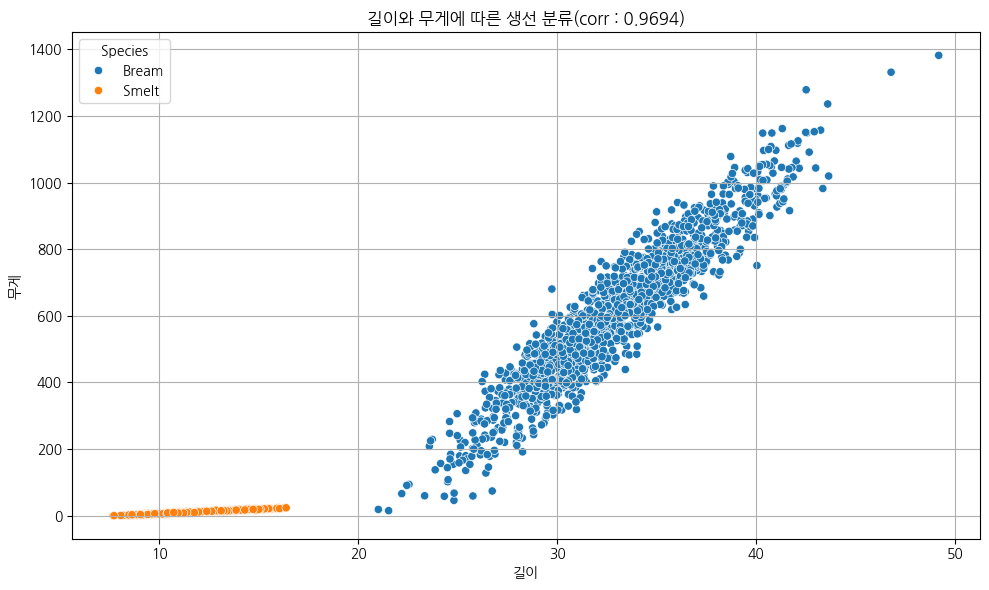

In [69]:
# ========================================================
# [1-3] 길이와 무게, 품종 관계 시각화
# ========================================================
corr_ = dataDF.corr(numeric_only=True)
print(dataDF.corr(numeric_only=True))

plt.figure(figsize=(10, 6))
sns.scatterplot(data=dataDF, x='Length', y='Weight', hue='Species')
plt.title(f"길이와 무게에 따른 생선 분류(corr : {corr_['Weight']['Length']:.4f})")
plt.xlabel('길이')
plt.ylabel('무게')
plt.grid(True)
plt.tight_layout()

[2] 피쳐와 타겟/학습용과 테스트용 분리 <hr>

In [70]:
# ========================================================
# [2-1] 피쳐와 타겟 분리
# ========================================================
featureDF = dataDF[dataDF.columns[1:-1]]
targetSR = dataDF[dataDF.columns[0]]
print(featureDF)
print(f"featureDF : {featureDF.shape}, targetSR : {targetSR.shape}")

        Length
0     32.42375
1     41.36527
2     33.44470
3     35.68641
4     33.52775
...        ...
10495 11.21824
10496 13.10661
10497 12.38393
10498 10.94337
10499 10.72247

[3000 rows x 1 columns]
featureDF : (3000, 1), targetSR : (3000,)


In [71]:
# ========================================================
# [2-2] 학습용과 테스트용 분리 : 회귀 시에는 stratify 필요 없음
#                             분류 시에는 클래스/라벨별 비율 설정을 위해서 stratify 필요!
# ========================================================
x_train, x_test, y_train, y_test = train_test_split(featureDF,
                                                             targetSR,
                                                             test_size=0.2,
                                                             random_state=7)

print(f"[train] x_train : {x_train.shape}, y_train : {y_train.shape}")
print(f"[train] x_test : {x_train.shape}, y_test : {y_train.shape}")


[train] x_train : (2400, 1), y_train : (2400,)
[train] x_test : (2400, 1), y_test : (2400,)


In [72]:
# ========================================================
# 학습 진행
# ========================================================
# 모델 인스턴스 생성
dtModel = DecisionTreeRegressor(random_state=7)
dtModel

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,7
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [73]:
# 학습 진행 => 학습용 데이터셋만 사용
dtModel.fit(x_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,7
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [83]:
# 학습 후 학습용 데이터셋 기반 모델 파라미터 설정
# - 모델 파라미터 : 파라미터이름_
print('n_features_in_               : ', dtModel.n_features_in_)
print('feature_names_in_            : ', dtModel.feature_names_in_)
print('max_features_                : ', dtModel.max_features_)
print('feature_importances_         : ', dtModel.feature_importances_)
print('get_depth                    : ', dtModel.get_depth())

print('tree_children_left.shape     : ', dtModel.tree_.children_left.shape)
print('tree_children_right.shape    : ', dtModel.tree_.children_right.shape)

n_features_in_               :  1
feature_names_in_            :  ['Length']
max_features_                :  1
feature_importances_         :  [1.]
get_depth                    :  27
tree_children_left.shape     :  (4797,)
tree_children_right.shape    :  (4797,)


[4] 성능평가 <hr>

In [75]:
# 훈련용 성능평가 & 테스트용 성능평가 비교
train_score = dtModel.score(x_train, y_train)
test_score = dtModel.score(x_test, y_test)\

print(f"[trian_score] {train_score}")
print(f"[test_score]  {test_score}")

[trian_score] 0.9999342253321356
[test_score]  0.9608150770201805


[5] 예측 : 새로운 데이터 사용 <hr>
- predict(2D_새로운 피쳐) => 예측 무게 값
- n_neighbors의 무게를 추출 => 평균한 값과 예측 무게값이 같은지 체크

In [76]:
# =============================================================================
# 새로운 데이터
# =============================================================================

newDF = pd.DataFrame([[20], [3], [45], [60], [99], [400]], columns=dataDF.columns[1:-1])
display(newDF)

,Length
0,20
1,3
2,45
3,60
4,99
5,400


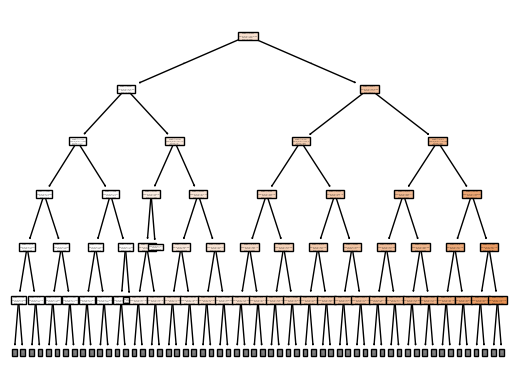

In [84]:
# =============================================================================
# DT의 그래프 시각화
# =============================================================================

from sklearn.tree import plot_tree

plot_tree(dtModel,
          feature_names=x_train.columns[0:1],
          class_names=[y_train.name],
          filled=True,
          max_depth=5)
plt.show()

In [78]:
# =============================================================================
# 예측값 추출
# =============================================================================

pre_weights = dtModel.predict(newDF)
print(f"[pre_weights] : {pre_weights}")

# =============================================================================
# 값을 예측한 경로
# =============================================================================

dtModel.decision_path(newDF).todense().tolist()


[pre_weights] : [  18.924735    0.022947 1019.842845 1331.508758 1331.508758 1331.508758]


[[1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,


NameError: name 'indices' is not defined

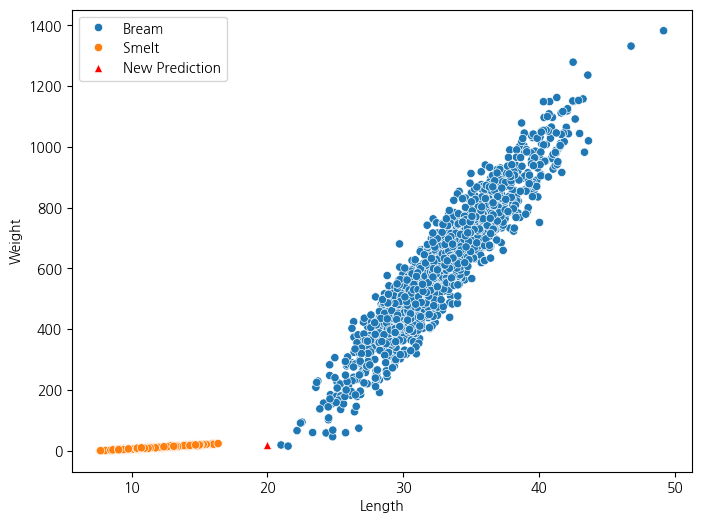

In [79]:

# =============================================================================
# 시각화
# =============================================================================

plt.figure(figsize=(8, 6))

# 기존 데이터셋
sns.scatterplot(data=dataDF, x='Length', y='Weight', hue='Species')

# newDF의 각 행마다 시각화
for row in range(len(newDF)):

    # 새로운 데이터
    predDF = pd.DataFrame({
        'Length': [newDF.iloc[row, 0]],
        'Weight': [pre_weights[row]]
    })
    
    sns.scatterplot(data=predDF, x='Length', y='Weight', color='red', 
                    marker='^', label='New Prediction' if row == 0 else '')
    
    # 최근접 이웃 데이터
    indices_ = indices[row].tolist()
    
    for idx, i in enumerate(indices_):
        if row == 0 and idx == 0:
            sns.scatterplot(x=x_train.iloc[i], y=y_train.iloc[i], 
                           color='yellow', label='Neighbors')
        else:
            sns.scatterplot(x=x_train.iloc[i], y=y_train.iloc[i], 
                           color='yellow')

plt.title(f"길이와 무게에 따른 생선 분류(corr : {corr_['Weight']['Length']:.4f})")

plt.xlabel('길이'); plt.ylabel('무게'); plt.legend()
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.show()
# =============================================================================\

[0] pre_weights :   65.28573        calc :   65.28573
[1] pre_weights :    0.69563        calc :    0.69563
[2] pre_weights : 1145.49170        calc : 1145.49170


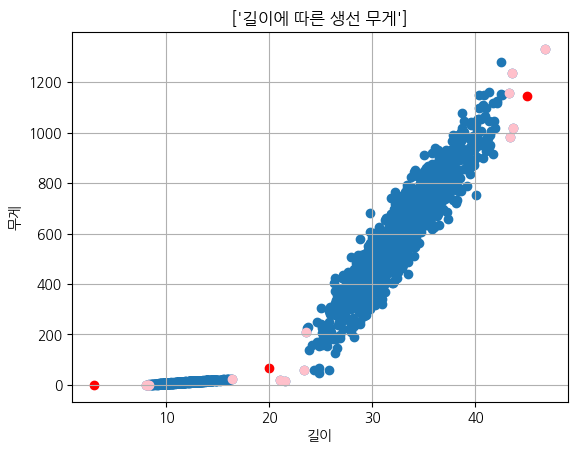

In [ ]:
## ==========================
## n_neighbors 시각화
## ==========================
plt.scatter(x_train, y_train)


for idx in range(newDF.shape[0]):

    # 최근접 이웃 인덱스 5개
    n_idx = indices[idx].tolist()

    plt.scatter(newDF.iloc[idx],     pre_weights[idx], c='red')
    plt.scatter(x_train.iloc[n_idx], y_train.iloc[n_idx], c='pink')
    
    print(f'[{idx}] pre_weights : {pre_weights[idx]:10.5f}', end='')
    print(f'        calc : {y_train.iloc[n_idx].sum()/5:10.5f}')

plt.xlabel('길이')
plt.ylabel('무게')
plt.grid()
plt.title([f"길이에 따른 생선 무게"])
plt.show()